# CelebA Training with Distance Weight

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

# created library
import mydata
from mymodels import TransDataset, LoadDataset, VGG16Model, ResNet50Model, EfficientB3Model

In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない
from distancetraining import ModelTrainer

# Efficientnet

In [3]:
db = "CelebA"
model_name = "efficientnet"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/polynomial_model_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_novel.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_novel.csv"

In [4]:
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

In [5]:
ycol="labels"
batch_size = 8 # １インプットずつペナルティを付加するため

ld = LoadDataset(df_train, df_valid, df_test, ycol, batch_size)
train_loader, valid_loader, test_loader = ld.create_dataloaders()

H*W:  (218, 178)


Validation Accuracy: 0.4920 | Loss: 0.0009 | F1: 0.0163 | AUC: 0.5757
Validation Accuracy: 0.4911 | Loss: 0.0008 | F1: 0.0199 | AUC: 0.6236
Validation Accuracy: 0.4963 | Loss: 0.0008 | F1: 0.0289 | AUC: 0.6919
Validation Accuracy: 0.5848 | Loss: 0.0008 | F1: 0.3427 | AUC: 0.7368
Validation Accuracy: 0.6406 | Loss: 0.0007 | F1: 0.4729 | AUC: 0.8089
Validation Accuracy: 0.7362 | Loss: 0.0005 | F1: 0.6659 | AUC: 0.8668
Validation Accuracy: 0.7793 | Loss: 0.0004 | F1: 0.7442 | AUC: 0.8822
Validation Accuracy: 0.7769 | Loss: 0.0004 | F1: 0.7302 | AUC: 0.8928
Validation Accuracy: 0.7610 | Loss: 0.0004 | F1: 0.7018 | AUC: 0.9038
Validation Accuracy: 0.7784 | Loss: 0.0004 | F1: 0.7308 | AUC: 0.9026
Validation Accuracy: 0.7338 | Loss: 0.0004 | F1: 0.6498 | AUC: 0.9182
Validation Accuracy: 0.8346 | Loss: 0.0003 | F1: 0.8223 | AUC: 0.9227
Validation Accuracy: 0.8149 | Loss: 0.0005 | F1: 0.7871 | AUC: 0.9010
Validation Accuracy: 0.8379 | Loss: 0.0005 | F1: 0.8177 | AUC: 0.9213
Validation Accuracy:

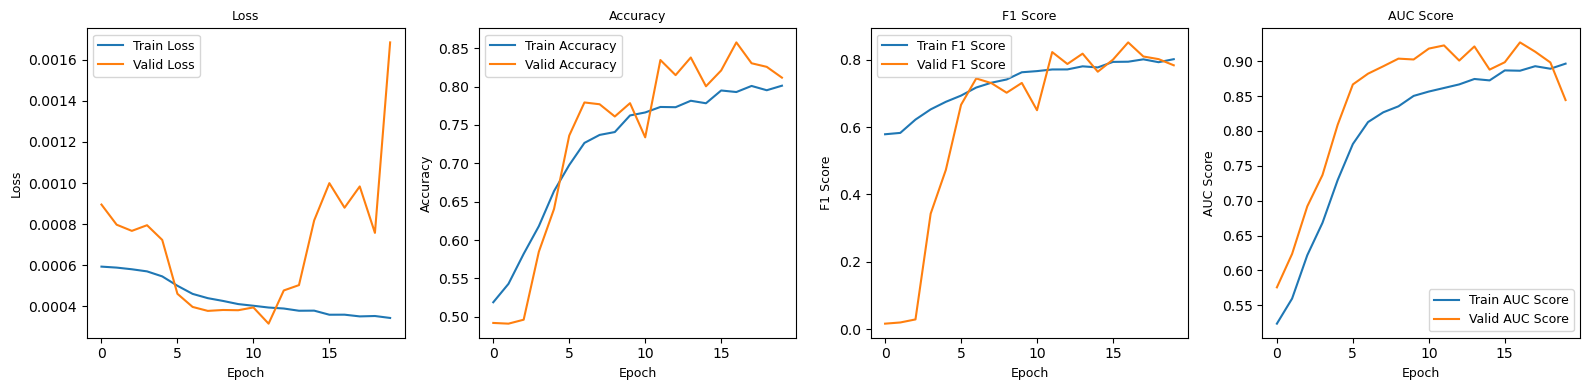

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientB3Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 20
lr = 0.00001
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, num_epochs=num_epochs, lr=lr)

In [7]:
model = EfficientB3Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

test_predictions = trainer.evaluate(model, valid_loader)
tmp = df_valid.copy()
tmp["predictions"] = test_predictions
tmp.to_csv(df_valid_filepath, index=False)

trainer.report(tmp)

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1049
           1       0.85      0.84      0.84      1085

    accuracy                           0.84      2134
   macro avg       0.84      0.84      0.84      2134
weighted avg       0.84      0.84      0.84      2134

Skin tone 1: Accuracy 0.8584817244611059
Skin tone 2: Accuracy 0.8275538894095595


In [8]:
test_predictions = trainer.evaluate(model, test_loader)
tmp = df_test.copy()
tmp["predictions"] = test_predictions
tmp.to_csv(df_test_filepath, index=False)

trainer.report(tmp)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1047
           1       0.86      0.85      0.86      1082

    accuracy                           0.85      2129
   macro avg       0.85      0.85      0.85      2129
weighted avg       0.85      0.85      0.85      2129

Skin tone 2: Accuracy 0.8589981447124304
Skin tone 1: Accuracy 0.8487155090390105


# Resnet

In [9]:
model_name = "resnet"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/polynomial_model_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_novel.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_novel.csv"

/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation Accuracy: 0.4930 | Loss: 0.0007 | F1: 0.0055 | AUC: 0.6768
Validation Accuracy: 0.6935 | Loss: 0.0005 | F1: 0.5697 | AUC: 0.8838
Validation Accuracy: 0.7652 | Loss: 0.0004 | F1: 0.6998 | AUC: 0.9382
Validation Accuracy: 0.8182 | Loss: 0.0003 | F1: 0.7835 | AUC: 0.9613
Validation Accuracy: 0.8575 | Loss: 0.0003 | F1: 0.8392 | AUC: 0.9647
Validation Accuracy: 0.8613 | Loss: 0.0003 | F1: 0.8437 | AUC: 0.9671
Validation Accuracy: 0.7460 | Loss: 0.0010 | F1: 0.6695 | AUC: 0.8136
Validation Accuracy: 0.8543 | Loss: 0.0003 | F1: 0.8345 | AUC: 0.9687
Validation Accuracy: 0.9053 | Loss: 0.0003 | F1: 0.9043 | AUC: 0.9577
Validation Accuracy: 0.8796 | Loss: 0.0003 | F1: 0.8684 | AUC: 0.9691
Validation Accuracy: 0.8782 | Loss: 0.0006 | F1: 0.8706 | AUC: 0.9506
Validation Accuracy: 0.8468 | Loss: 0.0004 | F1: 0.8615 | AUC: 0.9554
Validation Accuracy: 0.8993 | Loss: 0.0003 | F1: 0.8931 | AUC: 0.9673
Validation Accuracy: 0.9053 | Loss: 0.0002 | F1: 0.9019 | AUC: 0.9706
Validation Accuracy:

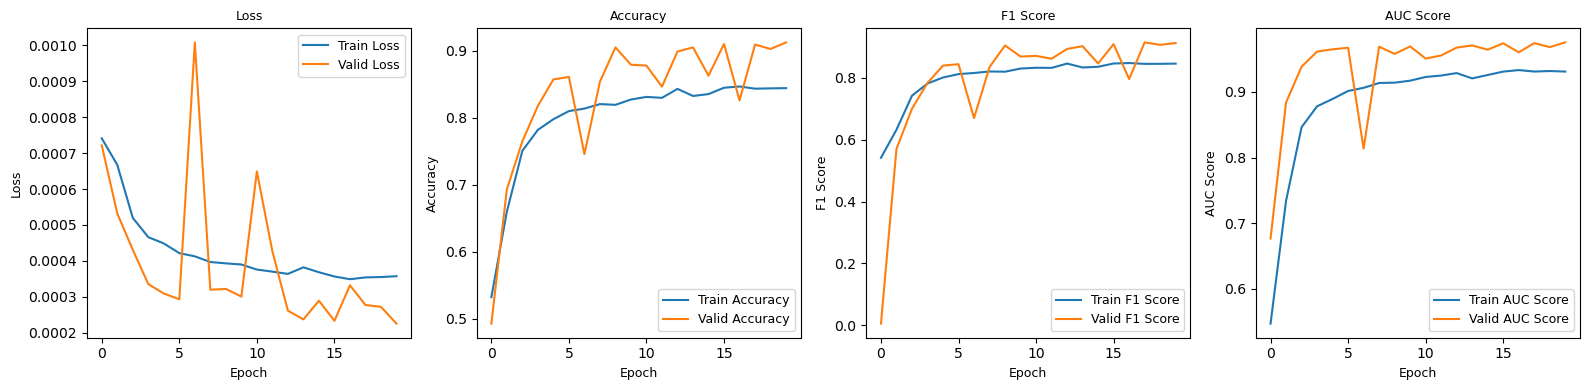

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 20
lr = 0.00001
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, num_epochs=num_epochs, lr=lr)

In [11]:
model = ResNet50Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

test_predictions = trainer.evaluate(model, valid_loader)
tmp = df_valid.copy()
tmp["predictions"] = test_predictions
tmp.to_csv(df_valid_filepath, index=False)

trainer.report(tmp)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1049
           1       0.92      0.91      0.91      1085

    accuracy                           0.91      2134
   macro avg       0.91      0.91      0.91      2134
weighted avg       0.91      0.91      0.91      2134

Skin tone 1: Accuracy 0.9231490159325211
Skin tone 2: Accuracy 0.9025304592314901


In [12]:
test_predictions = trainer.evaluate(model, test_loader)
tmp = df_test.copy()
tmp["predictions"] = test_predictions
tmp.to_csv(df_test_filepath, index=False)

trainer.report(tmp)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1047
           1       0.92      0.91      0.92      1082

    accuracy                           0.91      2129
   macro avg       0.91      0.91      0.91      2129
weighted avg       0.91      0.91      0.91      2129

Skin tone 2: Accuracy 0.9146567717996289
Skin tone 1: Accuracy 0.9143672692673644


# VGG

In [13]:
model_name = "vgg"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/polynomial_model_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_novel.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_novel.csv"

/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation Accuracy: 0.7020 | Loss: 0.0004 | F1: 0.5854 | AUC: 0.9352
Validation Accuracy: 0.8486 | Loss: 0.0002 | F1: 0.8274 | AUC: 0.9623
Validation Accuracy: 0.8946 | Loss: 0.0002 | F1: 0.8947 | AUC: 0.9625
Validation Accuracy: 0.8613 | Loss: 0.0002 | F1: 0.8442 | AUC: 0.9665
Validation Accuracy: 0.8716 | Loss: 0.0002 | F1: 0.8622 | AUC: 0.9551
Validation Accuracy: 0.8754 | Loss: 0.0003 | F1: 0.8690 | AUC: 0.9524
Validation Accuracy: 0.8613 | Loss: 0.0003 | F1: 0.8625 | AUC: 0.9419
Validation Accuracy: 0.8313 | Loss: 0.0004 | F1: 0.8399 | AUC: 0.9222
Validation Accuracy: 0.7474 | Loss: 0.0004 | F1: 0.6797 | AUC: 0.9016
Validation Accuracy: 0.6589 | Loss: 0.0005 | F1: 0.5101 | AUC: 0.8619
Validation Accuracy: 0.4916 | Loss: 0.0005 | F1: 0.0000 | AUC: 0.8005
Validation Accuracy: 0.4916 | Loss: 0.0005 | F1: 0.0000 | AUC: 0.7462
Validation Accuracy: 0.4916 | Loss: 0.0005 | F1: 0.0000 | AUC: 0.7007
Validation Accuracy: 0.4916 | Loss: 0.0005 | F1: 0.0000 | AUC: 0.5431
Validation Accuracy:

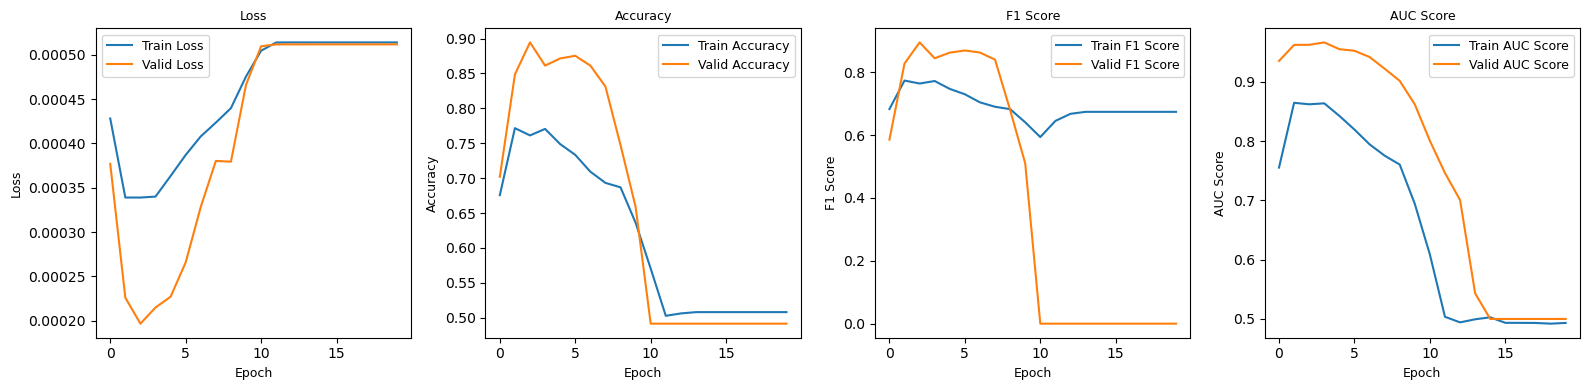

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 20
lr = 0.00001
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, num_epochs=num_epochs, lr=lr)

In [15]:
model = VGG16Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

test_predictions = trainer.evaluate(model, valid_loader)
tmp = df_valid.copy()
tmp["predictions"] = test_predictions
tmp.to_csv(df_valid_filepath, index=False)

trainer.report(tmp)

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1049
           1       0.87      0.92      0.89      1085

    accuracy                           0.89      2134
   macro avg       0.89      0.89      0.89      2134
weighted avg       0.89      0.89      0.89      2134

Skin tone 1: Accuracy 0.901593252108716
Skin tone 2: Accuracy 0.8753514526710403


In [16]:
test_predictions = trainer.evaluate(model, test_loader)
tmp = df_test.copy()
tmp["predictions"] = test_predictions
tmp.to_csv(df_test_filepath, index=False)

trainer.report(tmp)

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1047
           1       0.87      0.91      0.89      1082

    accuracy                           0.88      2129
   macro avg       0.88      0.88      0.88      2129
weighted avg       0.88      0.88      0.88      2129

Skin tone 2: Accuracy 0.8766233766233766
Skin tone 1: Accuracy 0.8896289248334919
